In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Otevřu soubor

In [3]:
rawfile = open('drive/My Drive/wd_russian.txt', 'r').read()
lines = rawfile.split("\n")

Rozdělím dle tabulátorů na X (anglická jména) a Y (ruská jména)

In [4]:
x_raw = [n.split('\t')[0] for n in lines if '\t' in n]
y_raw = [n.split('\t')[1] for n in lines if '\t' in n]

Trocha "normalizace" - konverze jmen ve formátu <příjmení, jméno> na <jméno příjmení>

In [5]:
def ss_check(name, ss):
  if ss in name:
    return True

  return False

def comma_check(name):
  return ss_check(name, ", ")

def comma_normalize(name):
  if not comma_check(name):
    return name

  first, second = name.split(', ', 1)
  return "% s % s"%(comma_normalize(second), first)


In [6]:
x_cnorm = [comma_normalize(x) for x in x_raw]
y_cnorm = [comma_normalize(x) for x in y_raw]

Ve zdrojových datech najdu zvláštní a nepoužívané znaky (méně než 50 použití, byl tam například $ nebo +),
jména s těmito znaky odstraním ze zdrojových dat.
Pak vytvořím tabulku znaků s indexy.

In [7]:
alltext = ''.join(x_cnorm) + ''.join(y_cnorm)
chars = sorted(list(set(alltext)))
cocc = {}
for c in chars:
  cocc[c] = alltext.count(c)

rarec = list(c for c in cocc if cocc[c] < 50)
badi = set()
for i, x in enumerate(x_cnorm):
  for rare in rarec:
    if rare in x:
      badi.add(i)

for i, x in enumerate(y_cnorm):
  for rare in rarec:
    if rare in x:
      badi.add(i)

In [8]:
x_pruned = [x for i, x in enumerate(x_cnorm) if i not in badi]
y_pruned = [x for i, x in enumerate(y_cnorm) if i not in badi]

alltext = ''.join(x_pruned) + ''.join(y_pruned)
chars = sorted(list(set(alltext)))

char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

Funkce tensorify vytvoří tenzor z jména (max 30 znaků).
Funkce textify zpětně vytvoří jméno z tenzoru.

Charify a Indify jsou pomocné funkce pro jednotlivé znaky používané výše uvedenými funkcemi.

In [9]:
def indify(char):
  ind = np.zeros(len(chars))
  ind[char] = 1
  return ind

def charify(ind):
  res = np.where(ind == np.amax(ind))
  return res[0][0]

def tensorify(text):
  text = text.strip().ljust(30)
  return np.array([indify(char_indices[x]) for x in list(text)][:30])

def textify(tensor):
  return "".join([indices_char[charify(x)] for x in tensor]).strip()

def textify2(tensor):
  return "".join([indices_char[charify(x)] for x in tensor[0][0]]).strip()

Vytvořím tenzor ze zdrojových dat, používám zde jen každé 20. jméno, protože kdybych jich tam dal víc, tak Colab hlásí překročení paměti.

In [10]:
x_tensor = [tensorify(x) for i, x in enumerate(x_pruned) if i % 20 == 6]
y_tensor = [tensorify(x) for i, x in enumerate(y_pruned) if i % 20 == 6]

Rozdělím na trénovací a testovací data.

In [11]:
x_train = np.array([x for i, x in enumerate(x_tensor) if not i % 20 == 7]).reshape(-1, 1, 30, len(chars))
x_test = np.array([x for i, x in enumerate(x_tensor) if i % 20 == 7]).reshape(-1, 1, 30, len(chars))
y_train = np.array([x for i, x in enumerate(y_tensor) if not i % 20 == 7]).reshape(-1, 1, 30, len(chars))
y_test = np.array([x for i, x in enumerate(y_tensor) if i % 20 == 7]).reshape(-1, 1, 30, len(chars))

Model se skládá z několika konvolučních vrstev, které čtou okolí jednotlivých znaků.

In [45]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, len(chars)), input_shape=(1, 30, len(chars)), activation='relu', padding="same"))
model.add(layers.Conv2D(16, (3, len(chars)), input_shape=(1, 30, len(chars)), activation='relu', padding="same"))
model.add(layers.Dense(len(chars), activation='softmax'))

In [46]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 1, 30, 32)         3613088   
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 30, 16)         298000    
_________________________________________________________________
dense_5 (Dense)              (None, 1, 30, 194)        3298      
Total params: 3,914,386
Trainable params: 3,914,386
Non-trainable params: 0
_________________________________________________________________


In [47]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [48]:
history = model.fit(x_train, y_train, epochs=30,
                    validation_data=(x_test, y_test),
                    batch_size=16)

Epoch 1/30
1193/1193 [==============================] - 33s 28ms/step - loss: 1.2925 - accuracy: 0.6851 - val_loss: 0.9311 - val_accuracy: 0.7654
Epoch 2/30
1193/1193 [==============================] - 33s 28ms/step - loss: 0.8490 - accuracy: 0.7797 - val_loss: 0.8122 - val_accuracy: 0.7876
Epoch 3/30
1193/1193 [==============================] - 33s 27ms/step - loss: 0.7649 - accuracy: 0.7966 - val_loss: 0.7688 - val_accuracy: 0.7951
Epoch 4/30
1193/1193 [==============================] - 33s 27ms/step - loss: 0.7175 - accuracy: 0.8069 - val_loss: 0.7364 - val_accuracy: 0.8052
Epoch 5/30
1193/1193 [==============================] - 33s 27ms/step - loss: 0.6783 - accuracy: 0.8161 - val_loss: 0.7205 - val_accuracy: 0.8104
Epoch 6/30
1193/1193 [==============================] - 33s 27ms/step - loss: 0.6461 - accuracy: 0.8247 - val_loss: 0.7075 - val_accuracy: 0.8141
Epoch 7/30
1193/1193 [==============================] - 33s 27ms/step - loss: 0.6185 - accuracy: 0.8316 - val_loss: 0.6987 -

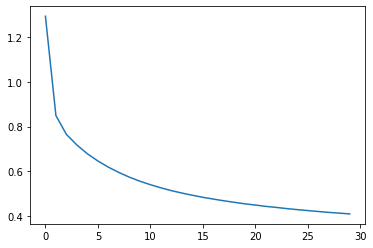

In [50]:
plt.plot(history.history['loss'])

Pomocná funkce pro použití modelu.

In [51]:
def translate(text):
  return textify2(model(tensorify(text).reshape(1, 1, 30, 194)))

In [81]:
def tas(text):
  display(text + " --> " + translate(text))

Použití této funkce:

In [84]:
tas("John")
tas("Thomas")
tas("Mortimer")
tas("Mortipher")
tas("Arnold")
tas("Lord Manager")
tas("Sam Sung")
display("")
tas("Dan Shark")
tas("Bruce Wayne")
tas("Peter Brown")
tas("Martin Luther")
tas("James Bond")
tas("Max Brod")
display("")
tas("Sunshine")
tas("Snow Flake")

'John --> Джон'

'Thomas --> Томас'

'Mortimer --> Мортимер'

'Mortipher --> Мортифер'

'Arnold --> Арнольд'

'Lord Manager --> Лорд Манагер'

'Sam Sung --> Сам Сунг'

''

'Dan Shark --> Дэн Шаарк'

'Bruce Wayne --> Брус Уэйй'

'Peter Brown --> Питер Бруун'

'Martin Luther --> Мартин Лютерр'

'James Bond --> Джеймс Бндд'

'Max Brod --> Макс Бод'

''

'Sunshine --> Сннинни'

'Snow Flake --> Соо  Флакэ'